In [215]:
#%matplotlib notebook

In [255]:
import pathlib

import matplotlib
import pymimir as mi
import networkx as nx
import torch
import matplotlib.pyplot as plt
import numpy as np

In [300]:
blocks_instance = "medium"
run_name = "07-08_16-29-39"

In [301]:
blocks_domain = mi.DomainParser("../test/pddl_instances/blocks/domain.pddl").parse()
blocks_problem = mi.ProblemParser(
    f"../test/pddl_instances/blocks/{blocks_instance}.pddl").parse(
    blocks_domain)
space = mi.StateSpace.new(blocks_problem, mi.GroundedSuccessorGenerator(blocks_problem))

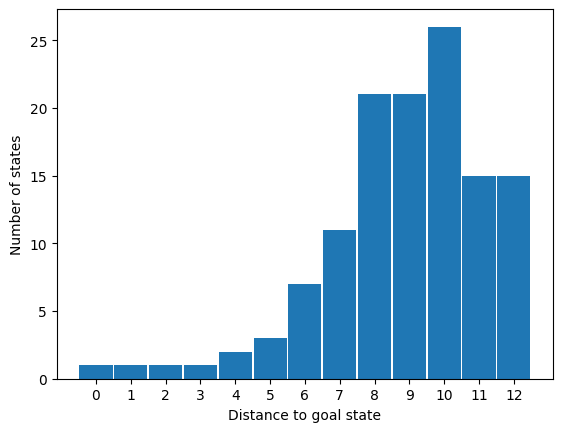

In [302]:
# Draw a histogram over the distances to the goal state
# Display the x-tick number below in the middle of the bars
distances = [space.get_distance_to_goal_state(s) for s in space.get_states()]
unique_distances = len(set(distances))
plt.xlabel("Distance to goal state")
plt.ylabel("Number of states")
plt.hist(distances, bins=np.arange(unique_distances + 1) - 0.5, rwidth=0.95)
plt.xticks(range(unique_distances))
plt.show()

In [303]:
(space.get_distance_to_goal_state(space.get_initial_state()),
 max(space.get_distance_to_goal_state(s) for s in space.get_states()))

(6, 12)

In [304]:
out_dir = f"../out/{blocks_instance}/{run_name}/"

In [305]:
values = torch.load(out_dir + "values.pt")

In [306]:
gamma = 0.9
non_goal_states = [s for s in space.get_states() if not space.is_goal_state(s)]
distances = torch.tensor(
    [space.get_distance_to_goal_state(s) for s in non_goal_states],
    dtype=torch.int,
)
optimal_values = -(1 - gamma ** distances) / (1 - gamma)

In [307]:
optimal_values.unique()

tensor([-7.1757, -6.8619, -6.5132, -6.1258, -5.6953, -5.2170, -4.6856, -4.0951,
        -3.4390, -2.7100, -1.9000, -1.0000])

In [308]:
-1 * (gamma ** torch.arange(0, 12)).sum()

tensor(-7.1757)

# Investigate values

Values are the predictions for all non-goal states over each iteration.
Note that indices have to be shifted to adjust to the missing goa states.

We expect that the initial state starts with a highly negative value and converges to 0, as the actual distance will be greater than the initial prediction (of around 0.5).
Previously values are $\hat V(s) - V(s)$, prediction - optimal

In [309]:
sqavg_values = (values - optimal_values).square()
l1_values = torch.abs(values - optimal_values)

In [310]:
(total_iterations := len(values))

952

In [311]:
(initial_state_idx := next(
    i for i, s in enumerate(space.get_states()) if s == space.get_initial_state()))

0

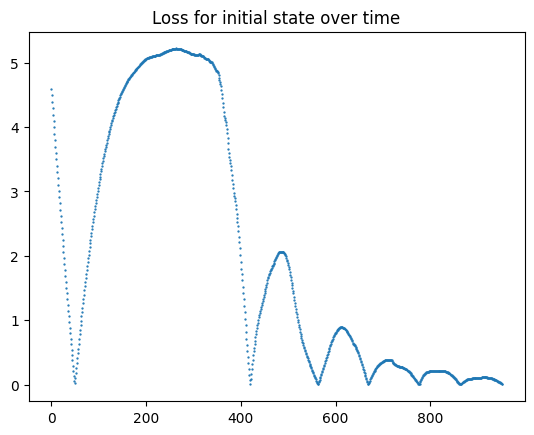

In [312]:
# plot values for initial state over all time steps
# remove outlier
start_it = 0
plt.scatter(torch.arange(start_it, total_iterations),
            l1_values[start_it:, initial_state_idx], s=0.4)
plt.title("Loss for initial state over time")
plt.show()

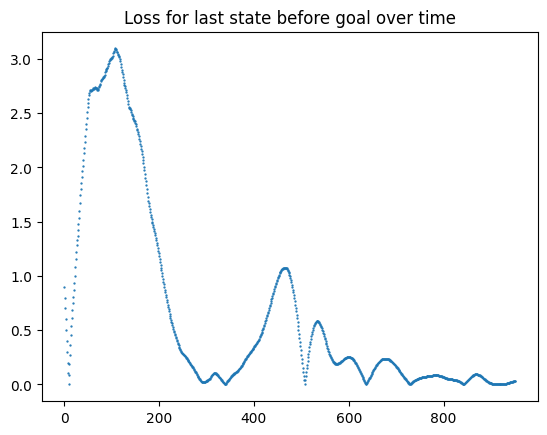

In [313]:
# plot values for last state before the goal over all time steps
one_before_goal = next(i for i, s in enumerate(space.get_states()) if
                       space.get_distance_to_goal_state(s) == 1)
start_it = 0
plt.scatter(torch.arange(start_it, total_iterations),
            l1_values[start_it:, one_before_goal], s=0.4)
plt.title("Loss for last state before goal over time")
plt.show()

In [314]:
values[-1]

tensor([-4.6748, -5.1939, -5.2547, -5.1865, -4.1026, -4.7042, -5.7001, -5.6619,
        -5.6686, -5.7238, -5.7544, -5.6586, -5.6594, -5.6824, -4.6795, -4.6785,
        -3.4691, -5.2019, -4.1172, -6.1356, -6.1392, -6.0900, -6.0901, -6.0873,
        -5.1972, -6.1308, -6.0935, -6.1254, -6.1309, -6.0879, -6.1322, -6.0887,
        -6.0895, -6.1145, -6.1419, -5.1950, -5.1933, -5.1912, -5.1832, -2.7529,
        -4.1089, -5.6737, -5.6710, -4.6965, -3.4749, -6.4946, -6.4988, -6.4976,
        -5.7323, -6.5214, -6.4800, -6.5148, -6.4806, -6.5285, -6.4669, -5.6649,
        -4.6851, -6.5008, -5.6663, -6.4799, -6.4867, -6.4941, -6.4915, -6.4793,
        -5.6771, -6.5305, -6.4809, -5.6640, -6.4947, -6.4778, -6.5072, -5.6670,
        -5.6652, -5.6632, -5.6717, -1.9453, -4.6908, -6.0880, -5.2186, -6.8236,
        -6.8373, -6.8395, -6.8842, -6.8602, -6.1523, -6.8429, -6.8313, -6.7986,
        -6.8313, -6.8279, -6.8795, -6.8402, -6.8518, -6.8050, -6.8391, -6.0930,
        -6.0924, -6.0907, -6.1340, -1.03

In [315]:
mse_loss = torch.mean(sqavg_values, dim=1)

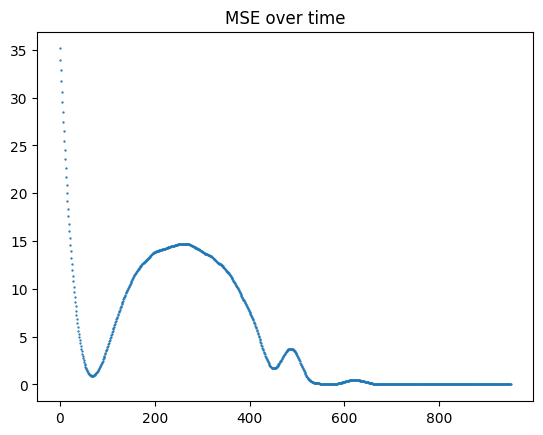

In [316]:
plt.scatter(torch.arange(start_it, total_iterations), mse_loss[start_it:], s=0.4)
plt.title("MSE over time")
plt.show()

In [317]:
torch.mean(values[-1]), torch.std(values[-1]), torch.max(values[-1])

(tensor(-5.9784), tensor(1.0410), tensor(-1.0344))

## Visualize the loss components over time

In [318]:
loss_files = pathlib.Path(out_dir).glob("loss_*")
losses = {file.stem: torch.load(file) for file in loss_files}

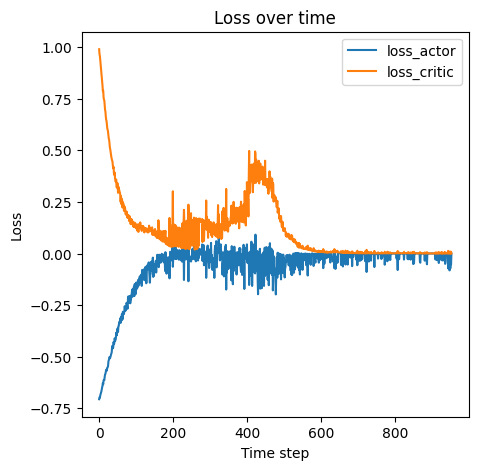

In [319]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title("Loss over time")
ax.set_xlabel("Time step")
ax.set_ylabel("Loss")
for name, loss in losses.items():
    ax.plot(torch.arange(0, len(loss)), loss, label=name)
plt.legend(loc="upper right")
plt.show()

# Visualize the state space over time

In [320]:
vmax = l1_values.max()

vmin = torch.min(torch.zeros((1,), dtype=torch.float), l1_values.min())
vmax, vmin

(tensor(7.0976), tensor([0.]))

In [321]:
normalized = (l1_values - vmin) / (vmax - vmin)

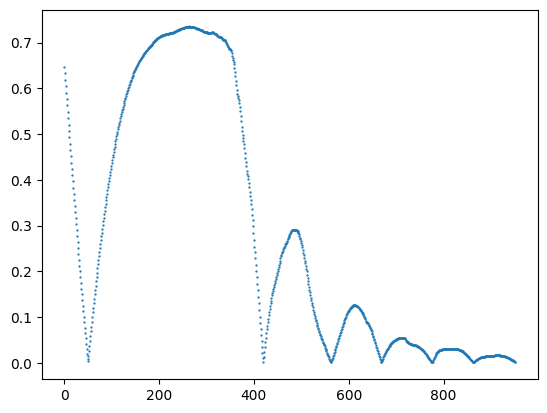

In [322]:
plt.scatter(torch.arange(start_it, total_iterations),
            normalized[start_it:, initial_state_idx], s=0.4)
plt.show()

In [286]:
graph = nx.DiGraph()
goal_indices = set()
for idx, state in enumerate(space.get_states()):
    if space.is_goal_state(state):
        goal_indices.add(idx)
    graph.add_node(state.__repr__(), idx=idx)
for state in space.get_states():
    for t in space.get_forward_transitions(state):
        graph.add_edge(
            t.source.__repr__(), t.target.__repr__(), action=t.action.schema.name
        )


In [287]:
goal_indices

{123}

In [288]:
def get_value(iteration, index):
    if index in goal_indices:
        return 0.0
    if index == 124:
        return normalized[iteration][index - 1].item()
    return normalized[iteration][index].item()

In [289]:
it_ = 0
get_value(it_, 0), get_value(it_, 1), get_value(it_, 2), get_value(it_, 3), get_value(
    it_, 4)

(0.6451165080070496,
 0.7131859660148621,
 0.7015061378479004,
 0.7035994529724121,
 0.5582193732261658)

In [241]:
pos = nx.spring_layout(graph, seed=42, iterations=2000)

In [290]:
from matplotlib.animation import FuncAnimation


#sm.set_array([])
def update_graph_plot(t, cmap, axis):
    axis.clear()
    # Normalize the values
    # Map node colors
    node_colors = [cmap(get_value(t, attr["idx"])) for _, attr in
                   graph.nodes.data()]

    # Draw the graph
    nx.draw_networkx(graph,
                     pos,
                     node_color=node_colors,
                     nodelist=[n for n in graph.nodes],
                     with_labels=False,
                     node_size=100,
                     arrowstyle="-",  # no arrows
                     ax=axis)

    axis.text(0.95, 0.95, f'Time step: {t}', horizontalalignment='right',
              verticalalignment='top', transform=axis.transAxes, fontsize=12,
              bbox=dict(facecolor='white', alpha=0.5))

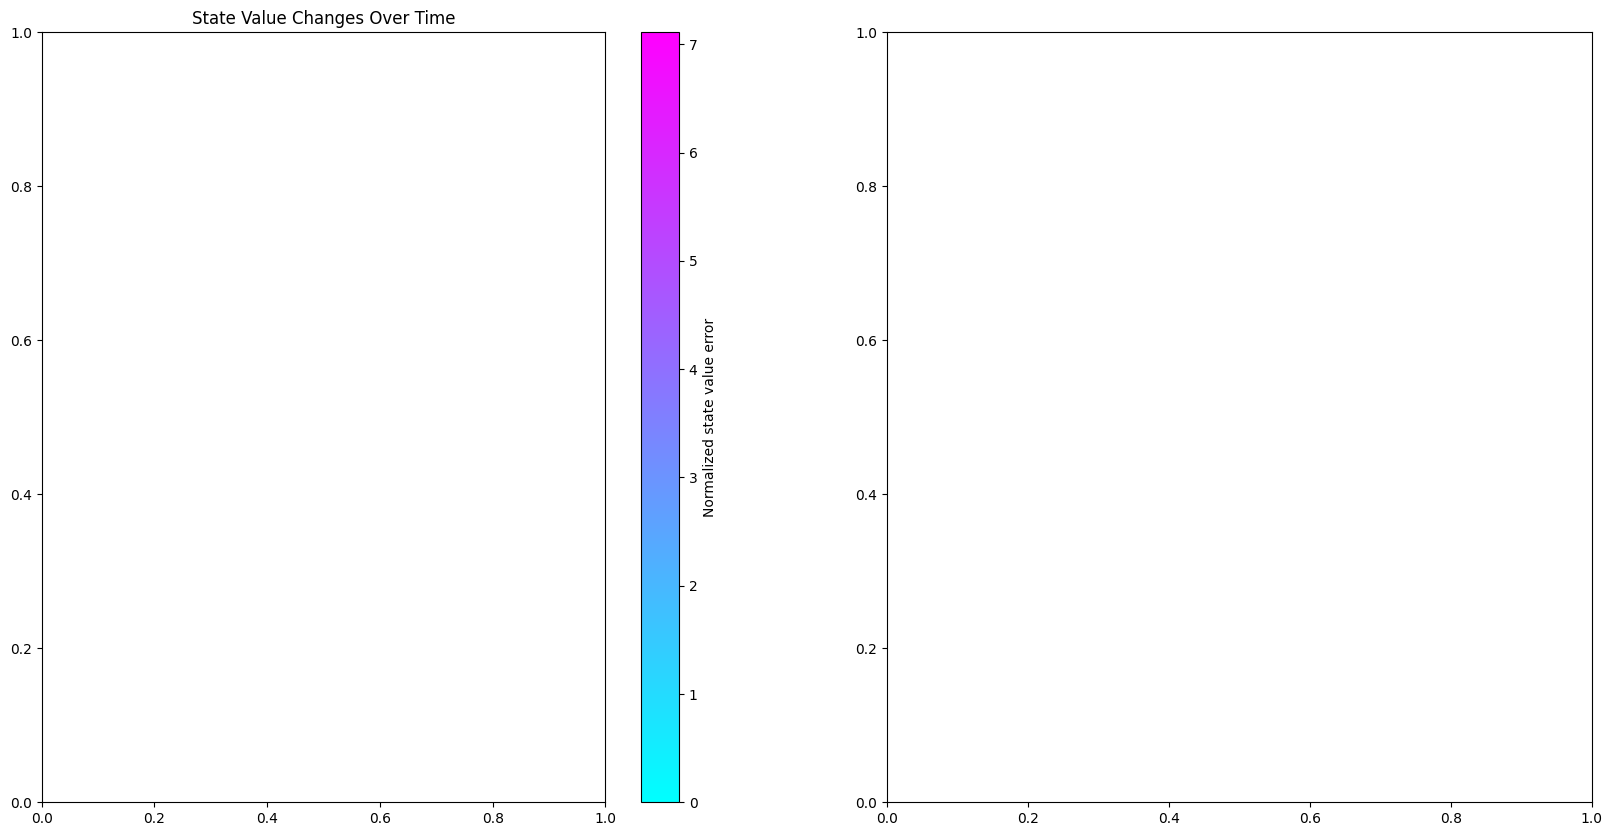

In [291]:
fig, (ax_graph, ax_line) = plt.subplots(figsize=(20, 10), ncols=2)
cmap = plt.cm.cool
normalized_cmap = matplotlib.colors.Normalize(vmin=vmin.item(), vmax=vmax.item())

sm = matplotlib.cm.ScalarMappable(norm=normalized_cmap, cmap=cmap)

ax_graph.set_title('State Value Changes Over Time')
fig.colorbar(sm, ax=ax_graph, orientation="vertical",
             label="Normalized state value error")


In [292]:
line, = ax_line.plot([], [], lw=2)

# Set up loss plot axes limits
ax_line.set_xlim(0, len(mse_loss))
ax_line.set_ylim(mse_loss.min().item(), mse_loss.max().item())
ax_line.set_title("Mean L1 loss over time")
ax_line.set_xlabel("Time step")
ax_line.set_ylabel("Mean L1 loss")


# Initialize your animation
def init():
    line.set_data([], [])
    return line,


def update_line_plot(t, line_data):
    # Update the mean loss line chart
    line_data.set_data(torch.arange(0, t), mse_loss[0:t])
    return line_data

In [293]:
def update(t, cmap, axis, line_data):
    update_graph_plot(t, cmap, axis)
    update_line_plot(t, line_data)
    return line_data

In [294]:
# Create the animation
ani = FuncAnimation(fig, lambda t: update(t, cmap, ax_graph, line), init_func=init,
                    frames=range(0, len(values), 10), repeat=False)

In [295]:
# Save the animation as a GIF
ani.save(f'../out/{blocks_instance}/{run_name}/graph_evolution_{blocks_instance}.gif',
         writer='pillow', fps=6)

## Visualize the policy decisions over time

In [249]:
probs_list_of_nested = torch.load(f"../out/{blocks_instance}/{run_name}/probs.pt")

In [250]:
edge_cmap = plt.cm.winter

In [251]:
from typing import List, Tuple
import itertools

edge_it = -1
edge_list: List[List[Tuple[str, str]]] = [
    [
        (t.source.__repr__(), t.target.__repr__()) for t in
        space.get_forward_transitions(s)
    ] for s in space.get_states()
]
edge_list = list(itertools.chain.from_iterable(edge_list))
probs_list = [[t.item() for t in trans_prob] for trans_prob in
              probs_list_of_nested[edge_it]]
probs_list = list(itertools.chain.from_iterable(probs_list))
edge_colors = list(map(edge_cmap, probs_list))

In [252]:
from matplotlib.animation import FuncAnimation


#sm.set_array([])
def update_edge_plot(time, axis):
    axis.clear()
    # Normalize the values
    # Map node colors
    probs_list = [[tensor.item() for tensor in trans_prob] for trans_prob in
                  probs_list_of_nested[time]]
    probs_list = list(itertools.chain.from_iterable(probs_list))

    # Draw the graph
    nx.draw_networkx_edges(graph, pos, ax=axis, node_size=100,
                           edgelist=edge_list,
                           edge_cmap=cmap,
                           alpha=probs_list,
                           connectionstyle="arc3,rad=0.2")

    nx.draw_networkx_nodes(graph, pos, ax=axis,
                           node_size=90, node_color="none",
                           linewidths=0.3, edgecolors="black")

    axis.text(0.95, 0.95, f'Time step: {time}', horizontalalignment='right',
              verticalalignment='top', transform=axis.transAxes, fontsize=12,
              bbox=dict(facecolor='white', alpha=0.5))

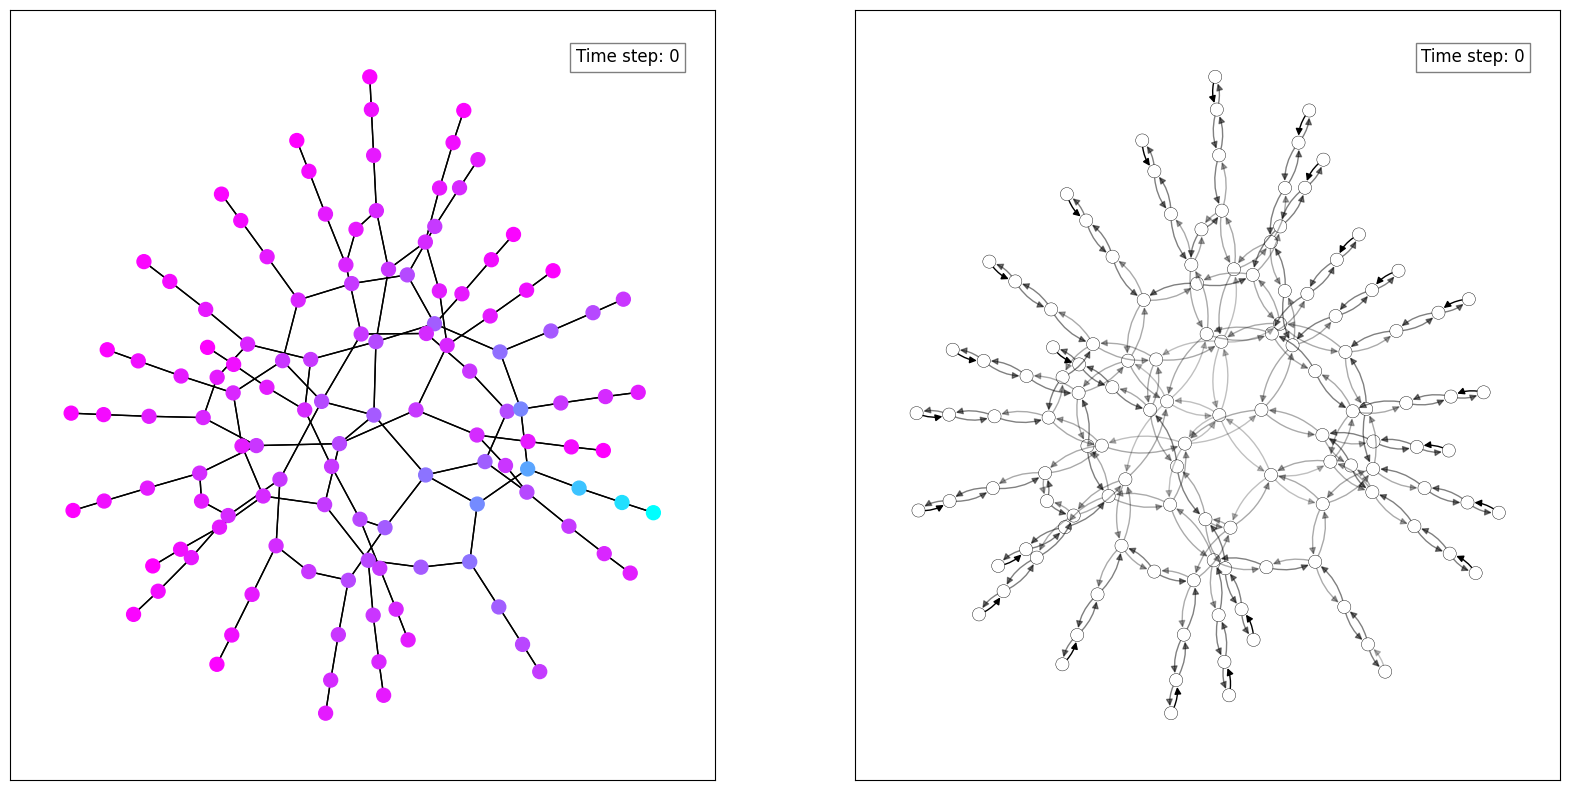

In [262]:
def update_nodes_and_edges(t, cmap, node_axis, edge_axis):
    update_graph_plot(t, cmap, node_axis)
    update_edge_plot(t, edge_axis)


fig, (ax_graph, ax_edges) = plt.subplots(figsize=(20, 10), ncols=2)
# Create the animation
ani = FuncAnimation(fig, lambda t: update_nodes_and_edges(t, cmap, ax_graph, ax_edges),
                    frames=range(0, len(values), 10), repeat=False)
# Save the animation as a GIF
ani.save(f'../out/{blocks_instance}/{run_name}/graph_with_probs_{blocks_instance}.gif',
         writer='pillow', fps=6)

In [ ]:
nx.drawing.nx_pydot.write_dot(graph,
                              "/work/rleap1/jakob.krude/projects/remote/rgnet/out/medium_blocks.dot")

In [ ]:
space.get_initial_state().__repr__().split(" ")[1][2:-2]

In [ ]:
out_graph = nx.Graph()


def get_id(s):
    return s.__repr__().split(" ")[1][2:-2]


for idx, state in enumerate(space.get_states()):
    if space.is_goal_state(state):
        type_ = "goal"
    elif space.get_initial_state() == state:
        type_ = "initial"
    else:
        type_ = "default"
    out_graph.add_node(get_id(state), type=type_)
for state in space.get_states():
    for t in space.get_forward_transitions(state):
        out_graph.add_edge(
            get_id(t.source), get_id(t.target), action=t.action.schema.name
        )

out_graph = nx.Graph.copy(out_graph, as_view=False)
nx.convert_node_labels_to_integers(out_graph)
nx.drawing.nx_pydot.write_dot(out_graph, f"../out/{blocks_instance}_blocks.dot")

## Train the supervised case completely in PyTorch as a sanity check

In [ ]:
non_goal_states = [s for s in space.get_states() if not space.is_goal_state(s)]
hidden_size = len(non_goal_states)
embeddings = torch.eye(hidden_size)
linear = torch.nn.Linear(hidden_size, 1)
optimal_values = torch.tensor(
    [space.get_distance_to_goal_state(s) for s in space.get_states() if
     not space.is_goal_state(s)],
    dtype=torch.float)
optim = torch.optim.Adam(linear.parameters(), lr=0.05)
optimal_values

In [ ]:
history = []
loss_history = []
iterations = 1000
for i in range(iterations):
    predictions = linear(embeddings)
    history.append(predictions.detach())
    loss = torch.nn.functional.l1_loss(predictions.squeeze(), optimal_values)
    loss_history.append(loss.detach())
    if loss < 0.1:
        break
    loss.backward()
    optim.step()
    optim.zero_grad()


In [ ]:
history_length = len(history)
history = torch.stack(history)
plt.scatter(torch.arange(0, history_length), history[:, 0], s=0.4)
plt.scatter(torch.arange(0, history_length), history[:, 1], s=0.4)
plt.scatter(torch.arange(0, history_length), history[:, 2], s=0.4)
plt.scatter(torch.arange(0, history_length), history[:, 3], s=0.4)
plt.show()

In [ ]:
plt.scatter(torch.arange(0, history_length), loss_history, s=0.4)

In [ ]:
torch.allclose(history[-1], optimal_values, atol=0.1)

In [297]:
(annealing_steps := 0.8 * len(values))

1600.0

In [298]:
change_per_step = (0.5 - 0.1) / annealing_steps

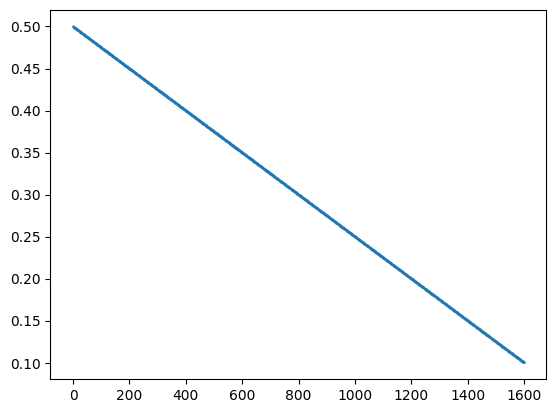

In [299]:
plt.scatter(torch.arange(0, len(values)*0.8), torch.arange(0.5,end=0.1,step=-change_per_step), s=0.4)
plt.show()